# Kde1d & Dependence Measures

This notebook demonstrates:
1. 1-D kernel density estimation (`Kde1d`)
2. Weighted dependence measures (`wdm`)
3. Pairs copula data visualization

In [1]:
import torch
import torchvine as tv
import matplotlib.pyplot as plt
torch.manual_seed(42)

## 1. Kernel Density Estimation (Kde1d)

Fit a 1-D KDE to data and evaluate PDF, CDF, and quantiles:

In [2]:
# Generate sample data
data = torch.randn(500, dtype=torch.float64)

kde = tv.Kde1d()
kde.fit(data)
print(f'Bandwidth:  {kde.bandwidth:.4f}')
print(f'Log-lik:    {kde.loglik:.2f}')
print(f'Obs:        {kde.nobs}')

Bandwidth:  0.2932
Log-lik:    -685.02
Obs:        500


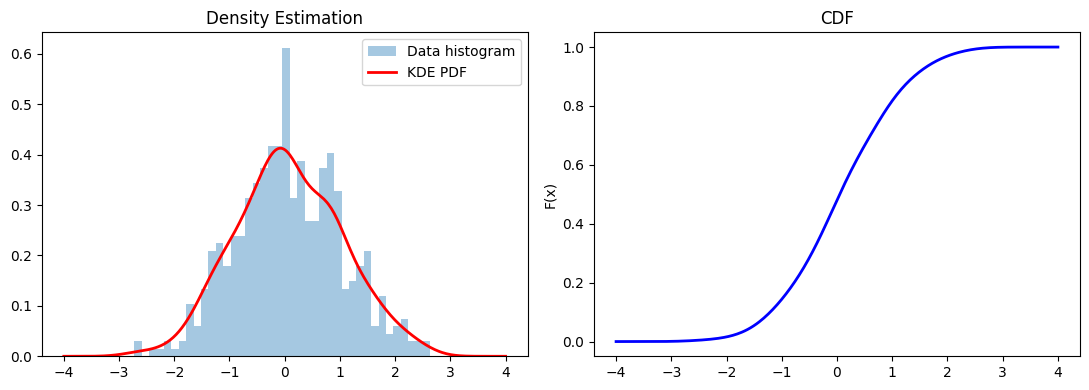

In [3]:
pts = torch.linspace(-4, 4, 300, dtype=torch.float64)
pdf = kde.pdf(pts)
cdf = kde.cdf(pts)

import numpy as np
pts_np = pts.numpy()
pdf_np = np.asarray(pdf)
cdf_np = np.asarray(cdf)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11, 4))

ax1.hist(data.numpy(), bins=40, density=True, alpha=0.4, label='Data histogram')
ax1.plot(pts_np, pdf_np, 'r-', lw=2, label='KDE PDF')
ax1.set_title('Density Estimation'); ax1.legend()

ax2.plot(pts_np, cdf_np, 'b-', lw=2)
ax2.set_title('CDF'); ax2.set_ylabel('F(x)')
plt.tight_layout()
plt.show()

### Quantiles

In [4]:
probs = torch.tensor([0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99], dtype=torch.float64)
quantiles = np.asarray(kde.quantile(probs))

print('Probability | Quantile')
print('-' * 25)
for p, q in zip(probs.tolist(), quantiles.tolist()):
    print(f'  {p:.2f}      | {q:+.3f}')

Probability | Quantile
-------------------------
  0.01      | -2.188
  0.05      | -1.537
  0.25      | -0.606
  0.50      | +0.048
  0.75      | +0.763
  0.95      | +1.773
  0.99      | +2.397


### Bounded Support

Kde1d supports bounded domains (e.g., positive data):

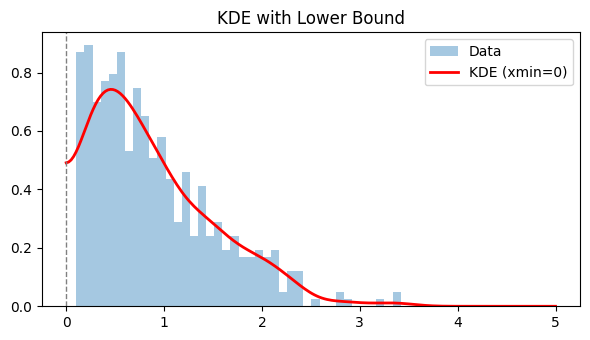

In [5]:
pos_data = torch.abs(torch.randn(500, dtype=torch.float64)) + 0.1

kde_bounded = tv.Kde1d(xmin=0.0)
kde_bounded.fit(pos_data)

pts_b = torch.linspace(0, 5, 200, dtype=torch.float64)
pdf_b = np.asarray(kde_bounded.pdf(pts_b))

plt.figure(figsize=(6, 3.5))
plt.hist(pos_data.numpy(), bins=40, density=True, alpha=0.4, label='Data')
plt.plot(pts_b.numpy(), pdf_b, 'r-', lw=2, label='KDE (xmin=0)')
plt.axvline(0, color='gray', ls='--', lw=1)
plt.title('KDE with Lower Bound'); plt.legend()
plt.tight_layout()
plt.show()

### Simulation from KDE

In [6]:
sim = kde.simulate(1000)
sim = np.asarray(sim)
print(f'Simulated shape: {sim.shape}')
print(f'Simulated mean:  {sim.mean():.3f}')
print(f'Simulated std:   {sim.std():.3f}')

Simulated shape: (1000,)
Simulated mean:  0.116
Simulated std:   1.008


## 2. Dependence Measures

All five classical dependence measures, implemented in pure PyTorch:

In [7]:
x = torch.randn(1000, dtype=torch.float64)
y = 0.6 * x + 0.8 * torch.randn(1000, dtype=torch.float64)

measures = {
    'Kendall τ':    tv.kendall_tau(x, y),
    'Spearman ρ':   tv.spearman_rho(x, y),
    'Pearson r':    tv.pearson_cor(x, y),
    'Blomqvist β':  tv.blomqvist_beta(x, y),
    'Hoeffding D':  tv.hoeffding_d(x, y),
}

print('Measure       | Value')
print('-' * 30)
for name, val in measures.items():
    print(f'{name:14s}| {val:.4f}')

Measure       | Value
------------------------------
Kendall τ     | 0.4018
Spearman ρ    | 0.5713
Pearson r     | 0.5995
Blomqvist β   | 0.3800
Hoeffding D   | 0.1062


### Using the `wdm()` Interface

The unified `wdm()` function mirrors pyvinecopulib:

In [8]:
methods = ['kendall', 'spearman', 'pearson', 'blomqvist', 'hoeffding']
for m in methods:
    print(f'wdm({m:>10s}) = {tv.wdm(x, y, m):.4f}')

wdm(   kendall) = 0.4018
wdm(  spearman) = 0.5713
wdm(   pearson) = 0.5995
wdm( blomqvist) = 0.3800
wdm( hoeffding) = 0.1062


## 3. Pairs Copula Data Visualization

Create a pairs plot showing copula density contours and Kendall's τ:

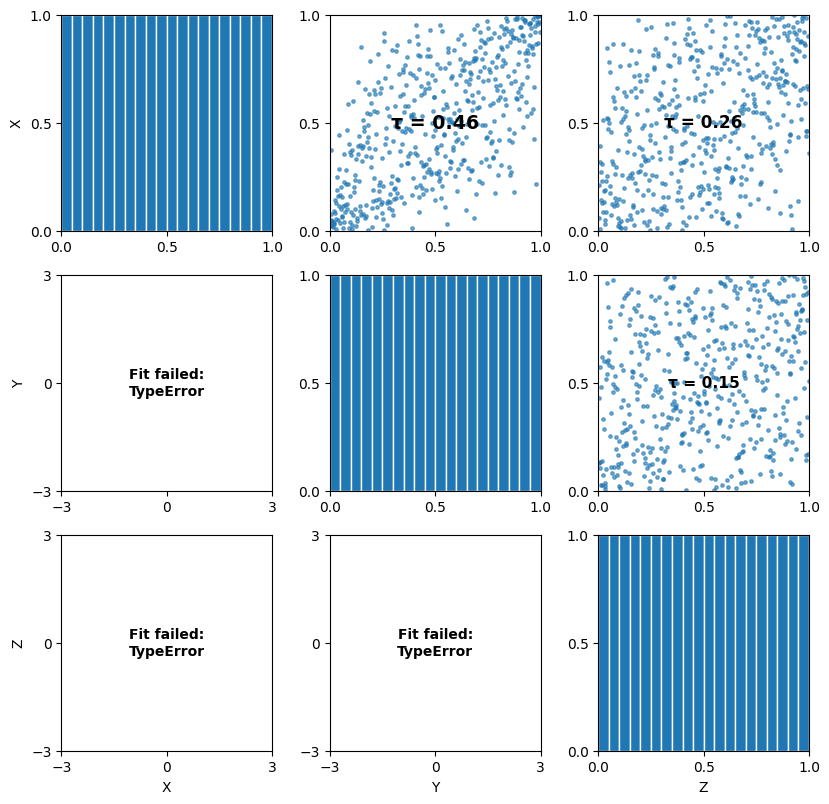

In [9]:
import math
n = 500
z = torch.randn(n, 3, dtype=torch.float64)
z[:, 1] = 0.7 * z[:, 0] + math.sqrt(1 - 0.49) * z[:, 1]
z[:, 2] = 0.4 * z[:, 0] + math.sqrt(1 - 0.16) * z[:, 2]
u = tv.to_pseudo_obs(z)

fig, axes = tv.pairs_copula_data(u, cols=['X', 'Y', 'Z'])
plt.show()

---

**All computations above are pure PyTorch — no NumPy, SciPy, or C++ dependencies needed.**